# Predicting Google stock prices Using RNN

This use-case provides a demo of how RNN and GRU can be used to model time series data. In our use-case, we will use 'Google stock price' data to predict the number of future stock prices based on the available historical data. You have been given a dataset that contains google stock prices from 2013 to 2018. We have to model the time series data using RNN GRU sequential model.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
#from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional,SimpleRNN
from keras.layers import Dense, Dropout, SimpleRNN
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

## Collecting the Data
The dataset trainset.csv will be used for the demo. The dataset contains google stock prices from 2013 to 2018. It has been downloaded from the site https://www.kaggle.com/ptheru/google-stock-price-prediction-rnn/data

In [2]:
gsheet_url="https://docs.google.com/spreadsheets/d/1Sqf4OdzWkm_BkfnSw2YAMF_J7vEApKu3uJosyqNgPrE/edit#gid=0"
url_1 = gsheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
print(url_1)


https://docs.google.com/spreadsheets/d/1Sqf4OdzWkm_BkfnSw2YAMF_J7vEApKu3uJosyqNgPrE/export?format=csv&gid=0


In [3]:
dataset = pd.read_csv(url_1, index_col='Date', parse_dates=['Date'])
print(dataset.shape)
dataset.head()

(1377, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2018-01-16 16:00:00,56.63,57.00,55.89,56.09,1575261
2018-01-17 16:00:00,56.31,56.63,55.85,56.60,1202639
2018-01-18 16:00:00,56.57,56.63,55.88,56.49,1198234
2018-01-19 16:00:00,56.59,56.89,56.42,56.88,1778229
2018-01-22 16:00:00,56.87,57.99,56.76,57.79,1617975


In [4]:
dataset.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2023-06-29 16:00:00,120.09,120.91,119.21,120.01,18517458
2023-06-30 16:00:00,121.10,122.03,120.88,120.97,23871764
2023-07-03 13:05:00,120.32,121.02,119.71,120.56,13888262
2023-07-05 16:00:00,120.06,123.37,120.06,122.63,17830347
2023-07-06 16:00:00,120.64,121.15,119.25,120.93,17750181


In [ ]:

# # dataset = pd.read_csv('/content/trainset.csv', index_col='Date', parse_dates=['Date'])
# dataset = pd.read_csv('trainset.csv', index_col='Date', parse_dates=['Date'])
# print(dataset.shape)
# dataset.head()

In [5]:
print(type(dataset))
print(type(dataset[:'2021']['High']))
print(type(dataset[:'2021']['High'].values))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [ ]:
dataset[   :'2021']['High'].values

In [8]:
print(dataset.shape)
x1 = dataset[:'2021']['High'].values
print(type(x1), x1.shape)
x2 = x1.reshape(-1, 1)
x2.shape

(1377, 5)
<class 'numpy.ndarray'> (999,)


(999, 1)

In [9]:
# Checking for missing values in Training and Test set
# training_set = dataset[:'2016']['High'].values  #taking the values from 'High' column
# test_set = dataset['2017':]['High'].values

# training_set = dataset[:'2016'].iloc[:,1:2].values  #taking the values from 'High' column
# test_set = dataset['2017':].iloc[:,1:2].values
training_set = dataset[:'2021']['High'].values.reshape(-1,1)  #taking the values from 'High' column
test_set = dataset['2022':]['High'].values.reshape(-1,1)
print(training_set.shape, test_set.shape, dataset.shape)
type(training_set), type(dataset)

(999, 1) (378, 1) (1377, 5)


(numpy.ndarray, pandas.core.frame.DataFrame)

In [10]:
training_set[:10]

array([[57.  ],
       [56.63],
       [56.63],
       [56.89],
       [57.99],
       [58.58],
       [58.99],
       [58.8 ],
       [58.79],
       [59.34]])

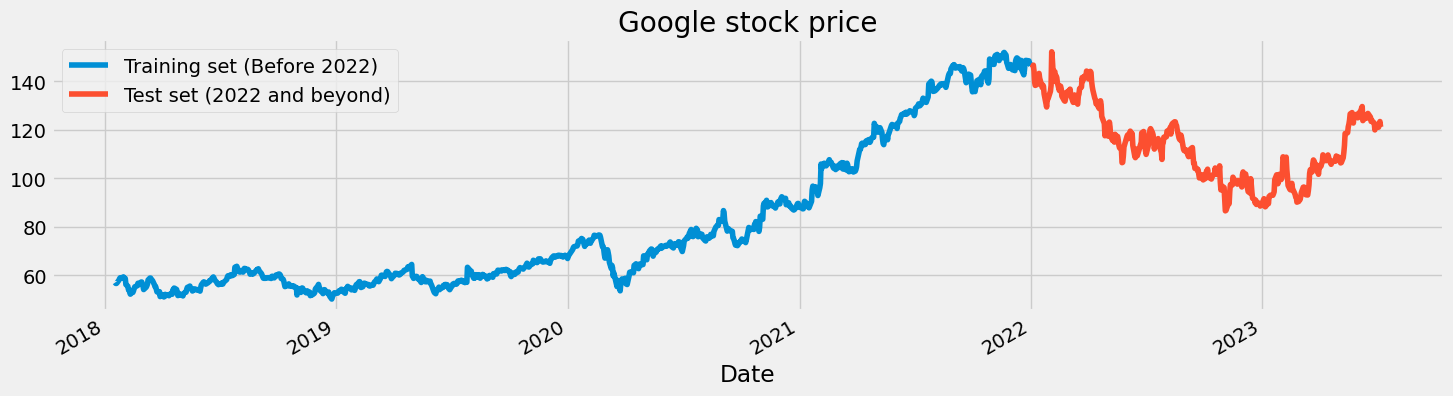

In [11]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2021'].plot(figsize=(16,4),legend=True)
dataset["High"]['2022':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2022)','Test set (2022 and beyond)'])
plt.title('Google stock price')
plt.show()

In [12]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled.shape

(999, 1)

In [13]:
training_set[:10]

array([[57.  ],
       [56.63],
       [56.63],
       [56.89],
       [57.99],
       [58.58],
       [58.99],
       [58.8 ],
       [58.79],
       [59.34]])

In [14]:
training_set_scaled[:10]

array([[0.06707977],
       [0.06344054],
       [0.06344054],
       [0.06599784],
       [0.07681715],
       [0.08262024],
       [0.0866529 ],
       [0.08478411],
       [0.08468575],
       [0.09009541]])

* We create a data structure with 60 timesteps and 1 output
* One row of X_train will have 60 sequential values, and y_train will have the 61st value

In [15]:

X_train = []
y_train = []
train_len = len(training_set_scaled)
for i in range(60,train_len):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(939, 60) (939,)


In [19]:
X_train[2], y_train[2]

(array([0.06344054, 0.06599784, 0.07681715, 0.08262024, 0.0866529 ,
        0.08478411, 0.08468575, 0.09009541, 0.08507918, 0.08330874,
        0.08380053, 0.05871939, 0.05232615, 0.03845776, 0.03845776,
        0.02704829, 0.0198682 , 0.02852365, 0.02694994, 0.03353988,
        0.04317891, 0.0496705 , 0.0542933 , 0.06412904, 0.05862103,
        0.06078489, 0.06904692, 0.06904692, 0.06098161, 0.05242451,
        0.03855611, 0.04603128, 0.0482935 , 0.05340808, 0.06098161,
        0.07730894, 0.08527589, 0.08517754, 0.07622701, 0.0774073 ,
        0.07485   , 0.0582276 , 0.04996557, 0.05045736, 0.0390479 ,
        0.02940887, 0.02557293, 0.03009737, 0.01013082, 0.01937641,
        0.01534376, 0.0085571 , 0.01239304, 0.01927806, 0.01367168,
        0.01770434, 0.01603226, 0.01367168, 0.01819612, 0.02104849]),
 0.019474771318973128)

For being used by the RNN/GRU/LSTM layers, we need the shape of X_train to be: [ batch_size, time_steps, Features ]
* We will use the full data in a single batch, so batch size will be 939
* There are 60 time steps
* At each time step, the price is the feature, which is of 1-dimension. Compare this with a word, which can have higher dimension based on the word embedding chosen

In [20]:
X_train.shape

(939, 60)

In [21]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)

(939, 60, 1)


## Create the model
* units - hidden layer dimension (no. of neurons)
* return sequences - when True, returns the output of each time step. Default False, returns the last output

In [23]:
model = Sequential()
model.add(SimpleRNN(50, input_shape=(X_train.shape[1],1), return_sequences=False, activation='tanh'))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


## Train the model

There aren't definitive results on one optimization algorithm being "better" than another. The common wisdom (which needs to be taken with a pound of salt) has been that Adam requires less experimentation to get convergence on the first try than SGD and variants thereof. However, this is highly dataset/model dependent. More recently some groups have made the claim that despite training faster, models trained with Adam generalize worse to the validation or test sets. See https://arxiv.org/abs/1712.07628 for more information.

Gradient descent optimization algorithms - nice blog - https://ruder.io/optimizing-gradient-descent/

In [24]:
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
7/7 [==============================] - 6s 37ms/step - loss: 0.1609
Epoch 2/50
7/7 [==============================] - 0s 41ms/step - loss: 0.0227
Epoch 3/50
7/7 [==============================] - 0s 42ms/step - loss: 0.0151
Epoch 4/50
7/7 [==============================] - 0s 65ms/step - loss: 0.0115
Epoch 5/50
7/7 [==============================] - 0s 38ms/step - loss: 0.0079
Epoch 6/50
7/7 [==============================] - 0s 34ms/step - loss: 0.0079
Epoch 7/50
7/7 [==============================] - 0s 35ms/step - loss: 0.0069
Epoch 8/50
7/7 [==============================] - 0s 35ms/step - loss: 0.0067
Epoch 9/50
7/7 [==============================] - 0s 34ms/step - loss: 0.0061
Epoch 10/50
7/7 [==============================] - 0s 35ms/step - loss: 0.0062
Epoch 11/50
7/7 [==============================] - 0s 39ms/step - loss: 0.0055
Epoch 12/50
7/7 [==============================] - 0s 35ms/step - loss: 0.0051
Epoch 13/50
7/7 [==============================] - 0s 33ms/st

## Test the model

* We use the previous 60 days’ stock prices to predict the next-day price
* So, we need the 60 days’ price before the 1st date in the test dataset.
* Accordingly, we create the input for prediction, index starting from the date 60 days before the first date in the test dataset.

In [25]:
test_set.shape

(378, 1)

In [26]:
# dataset_total = pd.concat((dataset["High"][:'2017'],dataset["High"]['2017':]),axis=0)
dataset_total = dataset["High"]
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values ## last 60 values of train_data + all values of test_data
print(len(dataset_total), len(test_set))
print(inputs.shape)
inputs = inputs.reshape(-1,1)
print(inputs.shape)
inputs  = sc.transform(inputs)

1377 378
(438,)
(438, 1)


In [27]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(inputs)):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
print(X_test.shape)
#X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test = np.expand_dims(X_test, 2)
print(X_test.shape)

(378, 60)
(378, 60, 1)


In [28]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

12/12 [==============================] - 0s 6ms/step


In [29]:
# Some functions to help out with predictions
def predictions_plot(test,predicted):
    plt.plot(test, color='red',label='Real Google Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Google Stock Price')
    plt.title('Google Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Google Stock Price')
    plt.legend()
    plt.show()

def rmse_return(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

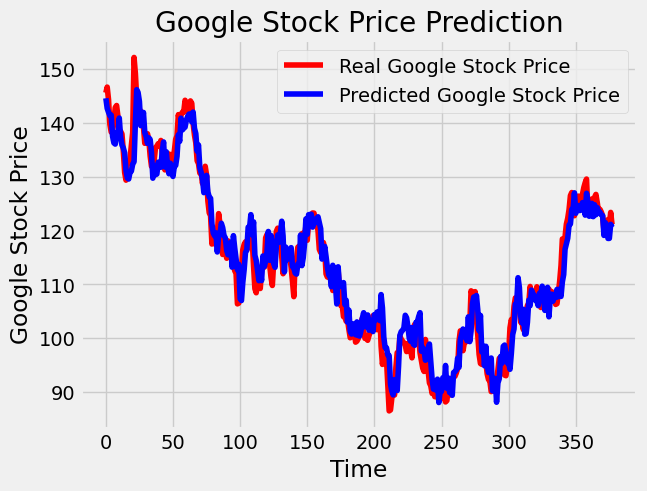

In [30]:
# Visualizing the results for GRU
predictions_plot(test_set,predicted_stock_price)

In [31]:
# Evaluating GRU
rmse_return(test_set,predicted_stock_price)

The root mean squared error is 3.4637323134612483.


In [32]:
test_set[:10]

array([[145.55],
       [146.61],
       [144.3 ],
       [139.69],
       [138.25],
       [138.64],
       [140.33],
       [142.81],
       [143.19],
       [141.2 ]])

In [33]:
predicted_stock_price[:10]

array([[144.53583],
       [142.65819],
       [141.94124],
       [141.31013],
       [141.40837],
       [137.48012],
       [136.25029],
       [136.03027],
       [138.17656],
       [137.88934]], dtype=float32)